<a href="https://colab.research.google.com/github/xseeker0/neural-scratchpad/blob/main/practice_3_2_non_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet model (the non sequential model)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.std import tqdm


# Load a dataset from Hugging face
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})


## Data

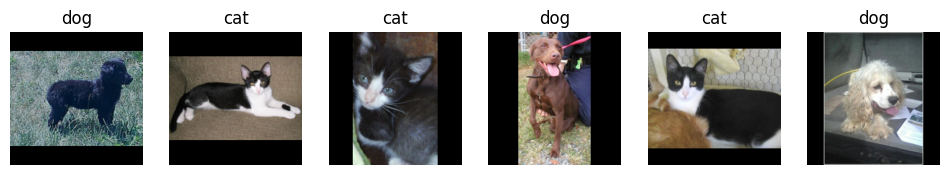

In [2]:
# Split 80/20
ds = ds["train"].train_test_split(
    test_size=0.2,
    seed=42
)

train_ds = ds["train"]
val_ds   = ds["test"]

class CatsDogsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]   # Raw PIL Image
        label = item["labels"]  # Target labels: 0 = cat, 1 = dog

        if self.transform:
            image = self.transform(image)

        return image, label

def letterbox(image: Image.Image, size: int = 224, fill: int | tuple = 0):
    w, h = image.size

    # Scale based on the longest side
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize while maintaining aspect ratio
    image = F.resize(image, (new_h, new_w))

    # Calculate required padding for each side
    pad_w = size - new_w
    pad_h = size - new_h

    padding = (
        pad_w // 2,               # left
        pad_h // 2,               # top
        pad_w - pad_w // 2,       # right
        pad_h - pad_h // 2        # bottom
    )

    # Apply padding and ensure output is in RGB format
    image = F.pad(image, padding, fill=fill)
    return image.convert("RGB")

transform = transforms.Compose([
    transforms.Lambda(lambda img: letterbox(img, size=224, fill=0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std =[0.229, 0.224, 0.225]    # ImageNet std
    )
])

train_dataset = CatsDogsDataset(train_ds, transform=transform)
val_dataset   = CatsDogsDataset(val_ds, transform=transform)

batch_size = 32*2
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

def visualize_ds(images, labels, class_names=None, n=8):
    images = images[:n]
    labels = labels[:n]
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std  = np.array([0.229, 0.224, 0.225])
    images = (images * imagenet_std) + imagenet_mean
    images = np.clip(images, 0, 1)
    plt.figure(figsize=(n * 2, 3))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

        if class_names:
            plt.title(class_names[labels[i]])
        else:
            plt.title(f"Label: {labels[i].item()}")

    plt.show()

images, labels = next(iter(val_loader))
class_names = ["cat", "dog"]

visualize_ds(images, labels, class_names=class_names, n=6)

## Residual Block

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Skip Connection
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

## Model architect

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet Layer
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x))) # Corrected: use torch.relu
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

model = ResNet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

## Training loop

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 1e-3
epochs = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(
            train_loader,
            desc="Training",
            leave=False,
            unit="batch"
        )

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Update tqdm postfix
            train_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{100.*correct_train/total_train:.2f}%"
            })

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_bar = tqdm(
            val_loader,
            desc="Validation",
            leave=False
        )

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                val_bar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.*correct_val/total_val:.2f}%"
                })

        # SUMMARY
        print(f"Train Acc: {100.*correct_train/total_train:.2f}% | "
              f"Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val   Acc: {100.*correct_val/total_val:.2f}% | "
              f"Loss: {val_loss/len(val_loader):.4f}")
        print("-" * 30)

    torch.save(model.state_dict(), "cats_dogs_model.pth")
    return model, train_loss, val_loss, correct_train, correct_val, total_train, total_val

his = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)

cuda

Epoch 1/2


Train Acc: 63.19% | Loss: 0.6479
Val   Acc: 62.09% | Loss: 0.6943
------------------------------

Epoch 2/2


Train Acc: 68.41% | Loss: 0.5950
Val   Acc: 68.18% | Loss: 0.5931
------------------------------


In [9]:
# import gc
# del model, train_loader, val_loader, criterion, optimizer, his; gc.collect()
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     torch.cuda.reset_peak_memory_stats()
from google.colab import runtime
print("Shutting down now.")
runtime.unassign()

Shutting down now.
